In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("="*80)
print("STEP 6: MODEL COMPARISON")
print("="*80)

STEP 6: MODEL COMPARISON


In [2]:
# 6.1 LOADING DATA
print("\n6.1 Loading data...")

demand = pd.read_csv('demand_clean.csv')
plants = pd.read_csv('plants_clean.csv')
costs = pd.read_csv('costs_clean.csv')

# Features
demand_features = [col for col in demand.columns 
                   if col.startswith('DF') and col not in ['DF_region', 'DF_daytype']]
plant_features = [col for col in plants.columns if col.startswith('PF')]
all_features = demand_features + plant_features

# Combine
combined = costs.merge(demand[['Demand ID'] + demand_features], on='Demand ID')
combined = combined.merge(plants[['Plant ID'] + plant_features], on='Plant ID')

X = combined[all_features].values
y = combined['Cost_USD_per_MWh'].values

print(f" Data ready: {X.shape}")


6.1 Loading data...
 Data ready: (24000, 30)


In [3]:
# 6.2 LOADING RANDOM FOREST RESULTS FROM STEP 5
print("\n6.2 Loading Random Forest results from Step 5...")

# Load Step 5 results (NO re-training!)
step5_params = pd.read_csv('step5_best_params.csv')
step5_comparison = pd.read_csv('step5_comparison.csv')

rf_rmse = step5_comparison['step5_optimized_rmse'].values[0]
rf_params = {
    'n_estimators': int(step5_params['n_estimators'].values[0]),
    'max_depth': int(step5_params['max_depth'].values[0]),
    'min_samples_split': int(step5_params['min_samples_split'].values[0]),
    'min_samples_leaf': int(step5_params['min_samples_leaf'].values[0]),
    'random_state': 42,
    'n_jobs': -1
}

print(f" Random Forest RMSE: ${rf_rmse:.2f} (from Step 5)")
print(f" Parameters: {rf_params}")

# Train RF once just for feature importance
print("  Training RF for feature importance...")
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X, y)


6.2 Loading Random Forest results from Step 5...
 Random Forest RMSE: $10.51 (from Step 5)
 Parameters: {'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 42, 'n_jobs': -1}
  Training RF for feature importance...


RandomForestRegressor(max_depth=25, min_samples_leaf=2, min_samples_split=5,
                      n_jobs=-1, random_state=42)

In [4]:
# 6.3 TRAINING GRADIENT BOOSTING
print("\n6.3 Training Gradient Boosting...")

# Simple parameters
gb_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'min_samples_split': 2,
    'random_state': 42
}

print(f"\nGB Parameters: {gb_params}")

# Train once
print("\nTraining...")
start_time = time.time()

gb_model = GradientBoostingRegressor(**gb_params)
gb_model.fit(X, y)

gb_time = time.time() - start_time
print(f" Training complete: {gb_time:.2f}s")

# Quick RMSE estimate using train/test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain on split
gb_model_test = GradientBoostingRegressor(**gb_params)
gb_model_test.fit(X_train, y_train)
y_pred = gb_model_test.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" Gradient Boosting RMSE: ${gb_rmse:.2f}")


6.3 Training Gradient Boosting...

GB Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'min_samples_split': 2, 'random_state': 42}

Training...
 Training complete: 10.26s
 Gradient Boosting RMSE: $10.09


In [5]:
# 6.4 COMPARISON
print("\n6.4 Model Comparison:")

print("\n" + "="*80)
print("RESULTS")
print("="*80)

print(f"\n{'Model':<25} | {'RMSE':<12}")
print("-" * 40)
print(f"{'Random Forest':<25} | ${rf_rmse:>7.2f}  {'done : ' if rf_rmse <= gb_rmse else ''}")
print(f"{'Gradient Boosting':<25} | ${gb_rmse:>7.2f}  {'done : ' if gb_rmse < rf_rmse else ''}")

difference = abs(rf_rmse - gb_rmse)
winner = "Random Forest" if rf_rmse <= gb_rmse else "Gradient Boosting"

print(f"\n {winner}")
print(f"   Difference: ${difference:.2f} ({difference/max(rf_rmse, gb_rmse)*100:.2f}%)")



6.4 Model Comparison:

RESULTS

Model                     | RMSE        
----------------------------------------
Random Forest             | $  10.51  
Gradient Boosting         | $  10.09  done : 

 Gradient Boosting
   Difference: $0.42 (4.02%)


In [6]:
# 6.5 ANALYSIS
print("\n6.5 Analysis:")

print("\nRANDOM FOREST:")
print("  Strengths: Fast training, robust, less overfitting")
print("  Weaknesses: May miss complex patterns")

print("\nGRADIENT BOOSTING:")
print("  Strengths: High accuracy, learns from errors")
print("  Weaknesses: Slower, needs more tuning")


6.5 Analysis:

RANDOM FOREST:
  Strengths: Fast training, robust, less overfitting
  Weaknesses: May miss complex patterns

GRADIENT BOOSTING:
  Strengths: High accuracy, learns from errors
  Weaknesses: Slower, needs more tuning



6.6 Feature Importance...

Top 10 Features:
Feature      | RF       | GB       | Avg     
---------------------------------------------
PF5          | 0.0782 | 0.1102 | 0.0942
PF16         | 0.0437 | 0.0946 | 0.0692
PF7          | 0.0708 | 0.0651 | 0.0680
DF9          | 0.0598 | 0.0598 | 0.0598
DF3          | 0.0558 | 0.0583 | 0.0571
DF8          | 0.0531 | 0.0554 | 0.0543
PF15         | 0.0200 | 0.0758 | 0.0479
PF2          | 0.0202 | 0.0642 | 0.0422
DF12         | 0.0446 | 0.0351 | 0.0398
DF10         | 0.0488 | 0.0222 | 0.0355

6.7 Creating visualizations...


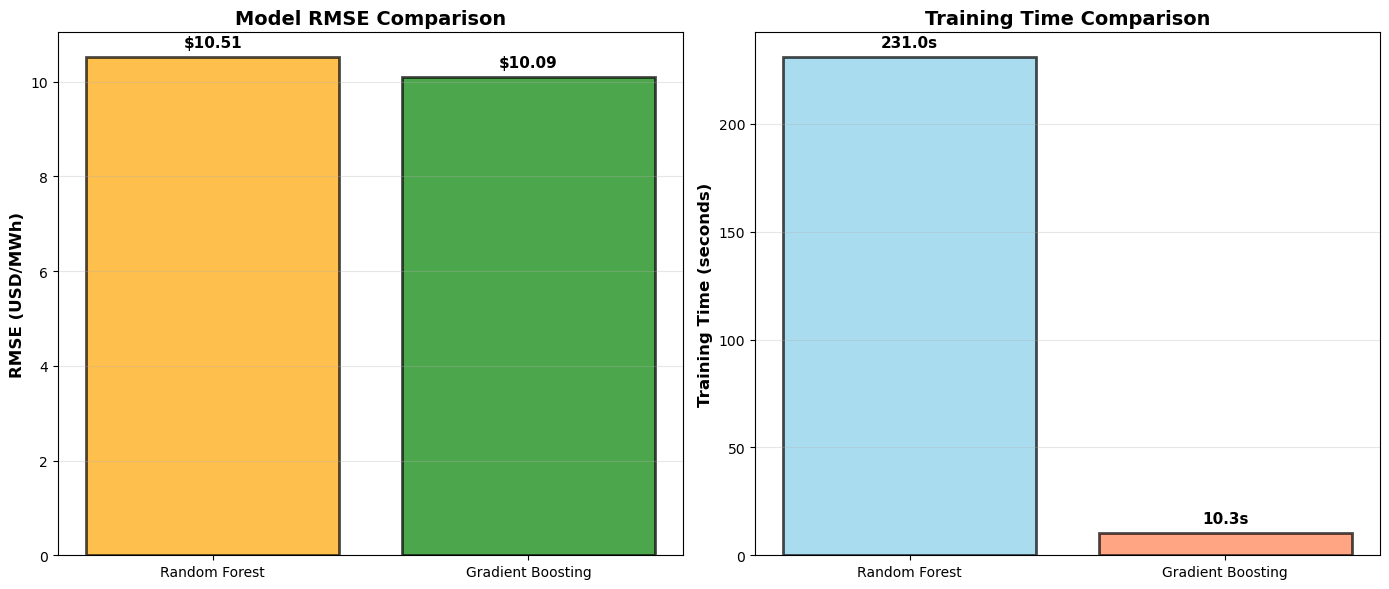

 Saved: fig_model_comparison.png


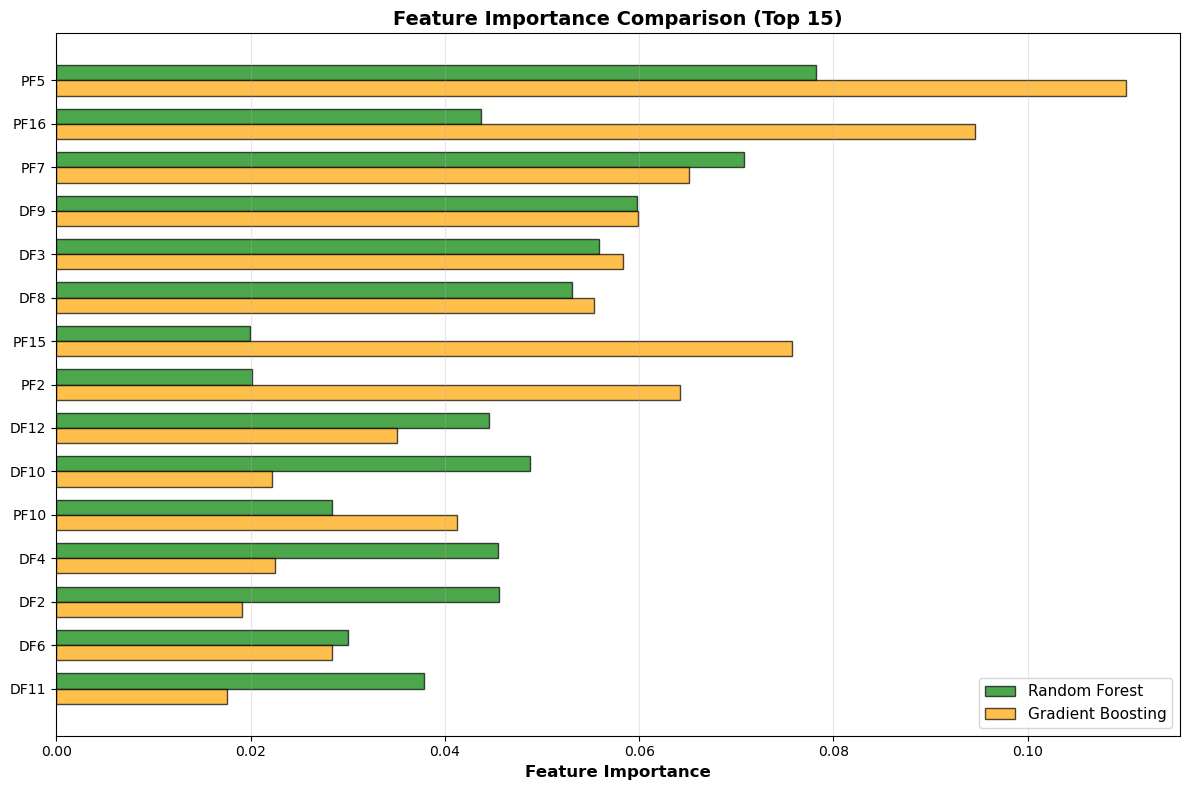

 Saved: fig_feature_importance_comparison.png


In [7]:
print("\n6.6 Feature Importance...")

rf_feat = pd.DataFrame({
    'Feature': all_features,
    'RF_Importance': rf_model.feature_importances_
})

gb_feat = pd.DataFrame({
    'Feature': all_features,
    'GB_Importance': gb_model.feature_importances_
})

feat_comp = rf_feat.merge(gb_feat, on='Feature')
feat_comp['Avg'] = (feat_comp['RF_Importance'] + feat_comp['GB_Importance']) / 2
feat_comp = feat_comp.sort_values('Avg', ascending=False)

print("\nTop 10 Features:")
print(f"{'Feature':<12} | {'RF':<8} | {'GB':<8} | {'Avg':<8}")
print("-" * 45)
for _, row in feat_comp.head(10).iterrows():
    print(f"{row['Feature']:<12} | {row['RF_Importance']:.4f} | "
          f"{row['GB_Importance']:.4f} | {row['Avg']:.4f}")

print("\n6.7 Creating visualizations...")

# Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE
models = ['Random Forest', 'Gradient Boosting']
rmses = [rf_rmse, gb_rmse]
colors = ['green' if r == min(rmses) else 'orange' for r in rmses]

axes[0].bar(models, rmses, color=colors, edgecolor='black', linewidth=2, alpha=0.7)
axes[0].set_ylabel('RMSE (USD/MWh)', fontweight='bold', fontsize=12)
axes[0].set_title('Model RMSE Comparison', fontweight='bold', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmses):
    axes[0].text(i, v + max(rmses)*0.02, f'${v:.2f}', 
                ha='center', fontweight='bold', fontsize=11)

# Training time
times = [step5_params['computation_time_seconds'].values[0], gb_time]
axes[1].bar(models, times, color=['skyblue', 'coral'], 
            edgecolor='black', linewidth=2, alpha=0.7)
axes[1].set_ylabel('Training Time (seconds)', fontweight='bold', fontsize=12)
axes[1].set_title('Training Time Comparison', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(times):
    axes[1].text(i, v + max(times)*0.02, f'{v:.1f}s', 
                ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('fig_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: fig_model_comparison.png")

# Feature Importance
fig, ax = plt.subplots(figsize=(12, 8))

top15 = feat_comp.head(15)
x = np.arange(len(top15))
width = 0.35

ax.barh(x - width/2, top15['RF_Importance'], width, 
        label='Random Forest', color='green', alpha=0.7, edgecolor='black')
ax.barh(x + width/2, top15['GB_Importance'], width,
        label='Gradient Boosting', color='orange', alpha=0.7, edgecolor='black')

ax.set_yticks(x)
ax.set_yticklabels(top15['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_title('Feature Importance Comparison (Top 15)', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: fig_feature_importance_comparison.png")


In [8]:
# SAVE RESULTS
print("\n6.8 Saving results...")

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'RMSE': [rf_rmse, gb_rmse],
    'Training_Time_sec': [step5_params['computation_time_seconds'].values[0], gb_time],
    'Parameters': [str(rf_params), str(gb_params)]
})
comparison.to_csv('step6_model_comparison.csv', index=False)
print(" Saved: step6_model_comparison.csv")

feat_comp.to_csv('step6_feature_importance_comparison.csv', index=False)
print(" Saved: step6_feature_importance_comparison.csv")



6.8 Saving results...
 Saved: step6_model_comparison.csv
 Saved: step6_feature_importance_comparison.csv
